# Naive Bayes Classification
Recall that the classifcation implied by Bayes Theorem:
$$\Pr(y=k|X=x)=\frac{\pi_kf_k(x)}{\sum_{l=1}^K\pi_lf_l(x)},$$
where $X\in\mathbb{R}^p, y\in\mathbb{R}^n$.
- For __LDA__, we have 
$$X|y=k\sim\mathcal{N}(\mu_k,\Sigma),\ then\ f_k(x)=\frac{1}{(2\pi)^{p/2}|\Sigma|^{1/2}}\exp(-\frac{1}{2}(x-\mu_k)^T\Sigma^{-1}(x-\mu_k)).$$
It assigns an observation $X=x$ to the class for which 
$$\delta_k(x)=x^T\Sigma^{-1}\mu_k-\frac{1}{2}\mu_k^T\Sigma^{-1}+\log\pi_k$$
is largest. $p(p+1)/2$ parameters to estimate in 
- For __QDA__, we have
$$X|y=k\sim\mathcal{N}(\mu_k,\color{red}{\Sigma_k}),\ then\ f_k(x)=\frac{1}{(2\pi)^{p/2}|\color{red}{\Sigma_k}|^{1/2}}\exp(-\frac{1}{2}(x-\mu_k)^T\color{red}{\Sigma_k}^{-1}(x-\mu_k)).$$
It assigns an observation $X=x$ to the class for which 
$$\delta_k(x)=\color{red}{-\frac{1}{2}x^T\Sigma_k^{-1}x}+x^T\color{red}{\Sigma_k}^{-1}\mu_k-\frac{1}{2}\mu_k^T\color{red}{\Sigma_k}^{-1}+\log\pi_k$$
is largest.

We can consider an even simpler model, the __Naive Bayes__,  which assumes __conditional independence__ between $X_j$'s:
$$X_j|y=k\sim\mathcal{N}(\mu_{jk},\sigma_{jk}^2),$$then$$f_k(x)=\prod_{j=1}^p\mathcal{N}(\mu_{jk},\sigma_{jk}^2)=\frac{1}{(2\pi)^{p/2}\color{red}{\prod_{j=1}^p\sigma_{jk}}}\exp(\sum_{j=1}^p-\frac{(x_j-\mu_{jk})^2}{2\color{red}{\sigma_{jk}^2}}).$$
- Equivalent to setting all the off-diagonal elements of $\Sigma$ in LAD to zero

We are going to compare the performance of Naive Bayes and LDA using simulation data

In [1]:
library(MASS)
library(klaR)
library(ggplot2)
options(warn=-1)

Warning message:
“package ‘ggplot2’ was built under R version 3.5.2”

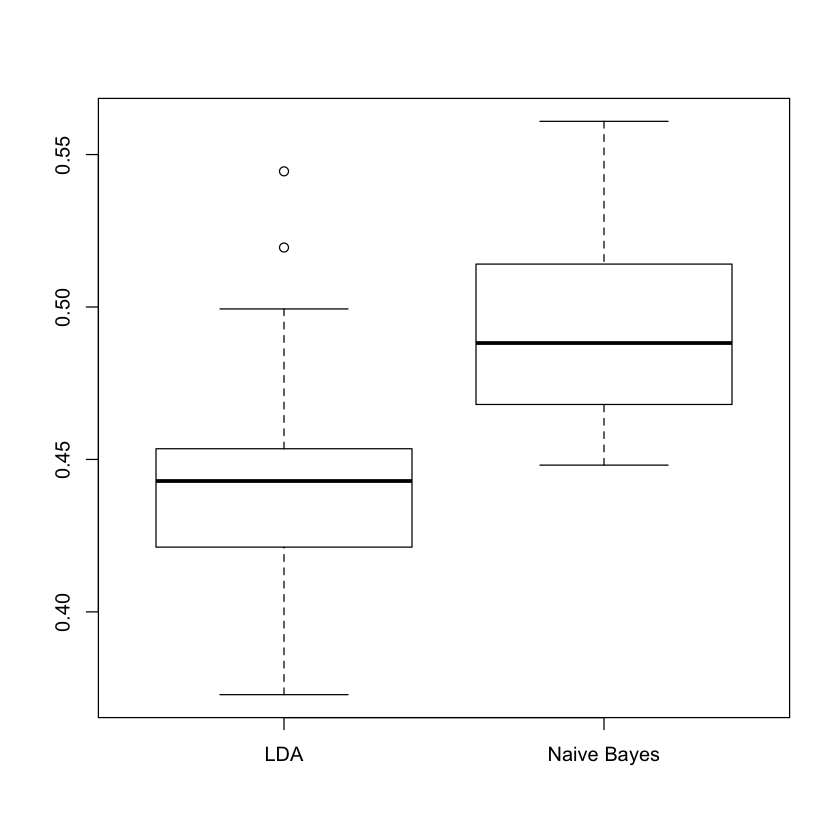

In [2]:
ntrain <- 200
ntest <- 500
n <- ntrain + ntest
idx_train <- 1:ntrain
idx_test <- (ntrain+1):n

p <- 15
beta <- rnorm(p)

trial <- 30
err <- matrix(0,trial,2)

for(i in 1:trial){
    X <- matrix(rnorm(n*p),n,p)
    t <- X%*%beta
    t <- t# + sqrt(c(var(t))*2)*rnorm(n)
    prob <- 1/(1+exp(-t))
    y <- rbinom(n,1,prob)
    dat <- data.frame(X,y=factor(y))
    
    fit_lda <- lda(y~.,dat,subset = idx_train)
    pred_lda=predict(fit_lda, dat[idx_test,])
    err_lda <- -sum(y[idx_test]*log(pred_lda$posterior[,2])+(1-y[idx_test])*log(pred_lda$posterior[,1]))/ntest
    err[i,1] <- err_lda

    fit_nb <- NaiveBayes(y~.,dat,subset = idx_train)
    pred_nb=predict(fit_nb, dat[idx_test,])
    err_nb <- -sum(y[idx_test]*log(pred_nb$posterior[,2])+(1-y[idx_test])*log(pred_nb$posterior[,1]))/ntest
    err[i,2] <- err_nb
}
colnames(err) <- c("LDA","Naive Bayes")
boxplot(err)


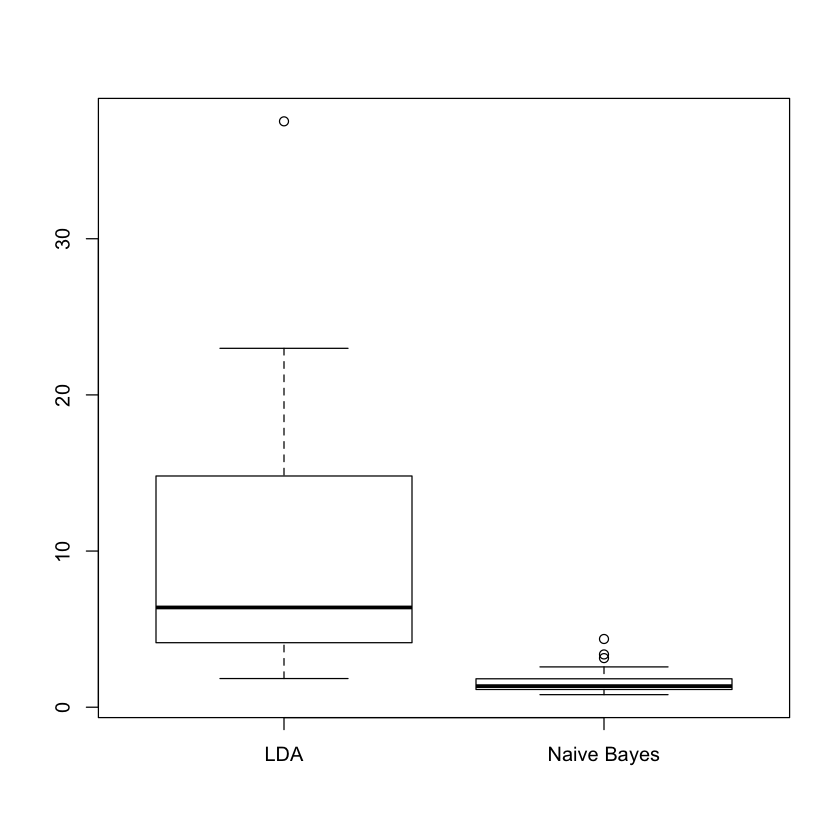

In [3]:
ntrain <- 20
ntest <- 500
n <- ntrain + ntest
idx_train <- 1:ntrain
idx_test <- (ntrain+1):n

p <- 15
beta <- rnorm(p)

trial <- 30
err <- matrix(0,trial,2)

for(i in 1:trial){
    X <- matrix(rnorm(n*p),n,p)
    t <- X%*%beta
    t <- t# + sqrt(c(var(t))*2)*rnorm(n)
    prob <- 1/(1+exp(-t))
    y <- rbinom(n,1,prob)
    dat <- data.frame(X,y=factor(y))
    
    fit_lda <- lda(y~.,dat,subset = idx_train)
    pred_lda=predict(fit_lda, dat[idx_test,])
    err_lda <- -sum(y[idx_test]*log(pred_lda$posterior[,2])+(1-y[idx_test])*log(pred_lda$posterior[,1]))/ntest
    err[i,1] <- err_lda

    fit_nb <- NaiveBayes(y~.,dat,subset = idx_train)
    pred_nb=predict(fit_nb, dat[idx_test,])
    err_nb <- -sum(y[idx_test]*log(pred_nb$posterior[,2])+(1-y[idx_test])*log(pred_nb$posterior[,1]))/ntest
    err[i,2] <- err_nb
}
colnames(err) <- c("LDA","Naive Bayes")
boxplot(err)

__bias-variance tradeoff__:
- LDA performs well when the samle size is large
- Naive Bayes can outperforms LDA with small sample size

# cross-validation
In application, dividing the data into training and testing set may be a waste of information. To make full use of the whole dataset, we can apply the cross-validation strategy.

- randomly partition the sample into $k$ equal sized subsamples
- Of the k subsamples, a single subsample is retained as the validation data for testing the model, and the remaining k − 1 subsamples are used as training data.
- The cross-validation process is then repeated k times, with each of the k subsamples used exactly once as the validation data. 
- The k results can then be averaged to produce a single estimation.
- All observations are used for both training and validation, and each observation is used for validation exactly once.
- 10-fold is usually used.

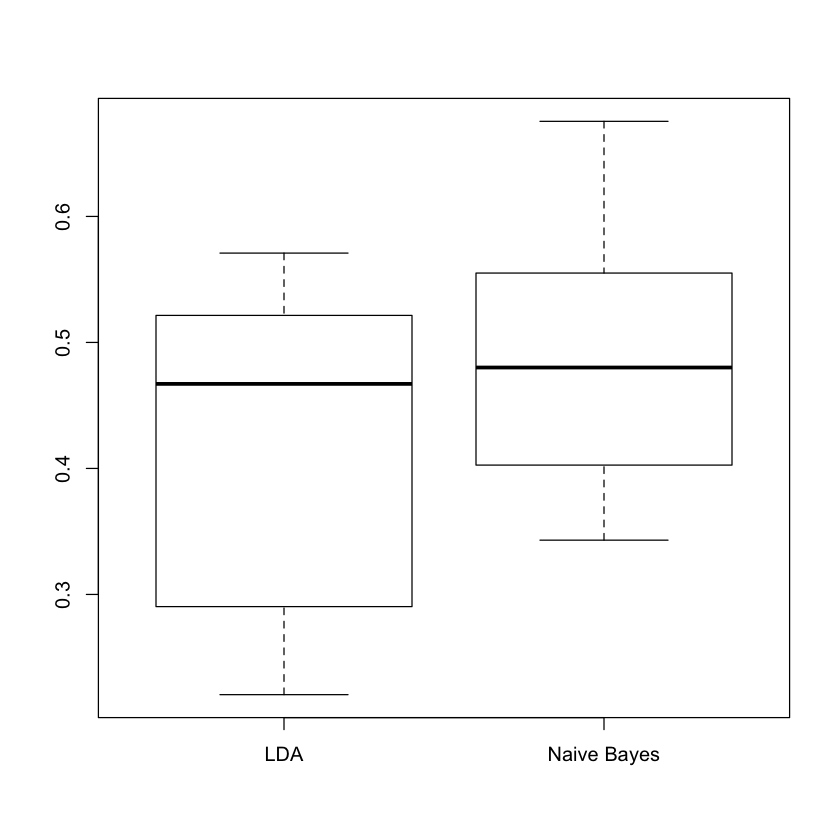

In [4]:
n <- 200
nfolds <- 10
X <- matrix(rnorm(n*p),n,p)
t <- X%*%beta
t <- t# + sqrt(c(var(t))*2)*rnorm(n)
prob <- 1/(1+exp(-t))
y <- rbinom(n,1,prob)
dat <- data.frame(X,y=factor(y))

p <- 15
beta <- rnorm(p)

dat_idx <- sample(1:n,n,replace = F)
cv_err <- matrix(0,nfolds,2)
for(i in 1:nfolds){
    idx_test <- dat_idx[((i-1)*n/nfolds+1):(i*n/nfolds)]
    
    fit_lda <- lda(y~.,dat,subset = -idx_test)
    pred_lda=predict(fit_lda, dat[idx_test,])
    err_lda <- -sum(y[idx_test]*log(pred_lda$posterior[,2])+(1-y[idx_test])*log(pred_lda$posterior[,1]))/(n/nfolds)
    cv_err[i,1] <- err_lda

    fit_nb <- NaiveBayes(y~.,dat,subset = -idx_test)
    pred_nb=predict(fit_nb, dat[idx_test,])
    err_nb <- -sum(y[idx_test]*log(pred_nb$posterior[,2])+(1-y[idx_test])*log(pred_nb$posterior[,1]))/(n/nfolds)
    cv_err[i,2] <- err_nb
}
colnames(cv_err) <- c("LDA","Naive Bayes")
boxplot(cv_err)

# Bootstrap

- The __bootstrap__ is a widely applicable and extremely powerful statistical tool that can be used to quantify the __uncertainty__ associated with a given estimator or statistical learning method.
- Frequently used to estimate the standard errors of the parameter estimates, especially when the closed form is difficult of obtain.

Consider a portfolio investment problem. 
- Given two financial assets $X$ and $Y$, where both are __random quantities__ with variance $\sigma_Y^2$, $
\sigma_X^2$ and covariance $\sigma_{XY}$. 
- Suppose we aim to minimize the __variability__ of a investment strategy that is a combination of $X$ and $Y$, i.e.,  $\min_{\alpha} Var(\alpha X + (1-\alpha)Y)$. 
- It is easy to show that the optimal $\alpha$ is obtained by $\alpha=\frac{\sigma_Y^2-\sigma_{XY}}{\sigma_X^2+\sigma_Y^2-2\sigma_{XY}}$.
- In real applications, $\sigma_X^2$, $\sigma_Y^2$ and $\sigma_{XY}$ are unknown, we can estimate these parameters from a dataset and hence obtain the estimate of $\alpha$: $$\hat{\alpha}=\frac{\hat{\sigma}_Y^2-\hat{\sigma}_{XY}}{\hat{\sigma}_X^2+\hat{\sigma}_Y^2-2\hat{\sigma}_{XY}}$$
- Here we generate simulation data by setting $\sigma_X^2=1$, $\sigma_Y^2=1.25$ and $\sigma_{XY}=0.5$. Then the ground truth is $\alpha=0.6$.
- If we sample $n=100$ potins of $(X,Y)$ to estimate $\alpha$ and repeat this procedure $m$ times, then we can compute the standard error of $\hat{\alpha}$ from the m estimates: $$\sqrt{\frac{1}{m-1}\sum_{i=1}^m(\hat{\alpha}_i-\frac{1}{m}\sum_{i=1}^m\hat{\alpha}_i)}$$
where $\hat{\alpha}_i$ is the estimate of $\alpha$ using the $i$-th dataset sampled form the population.

[1] 0.6001714

[1] 0.0822418

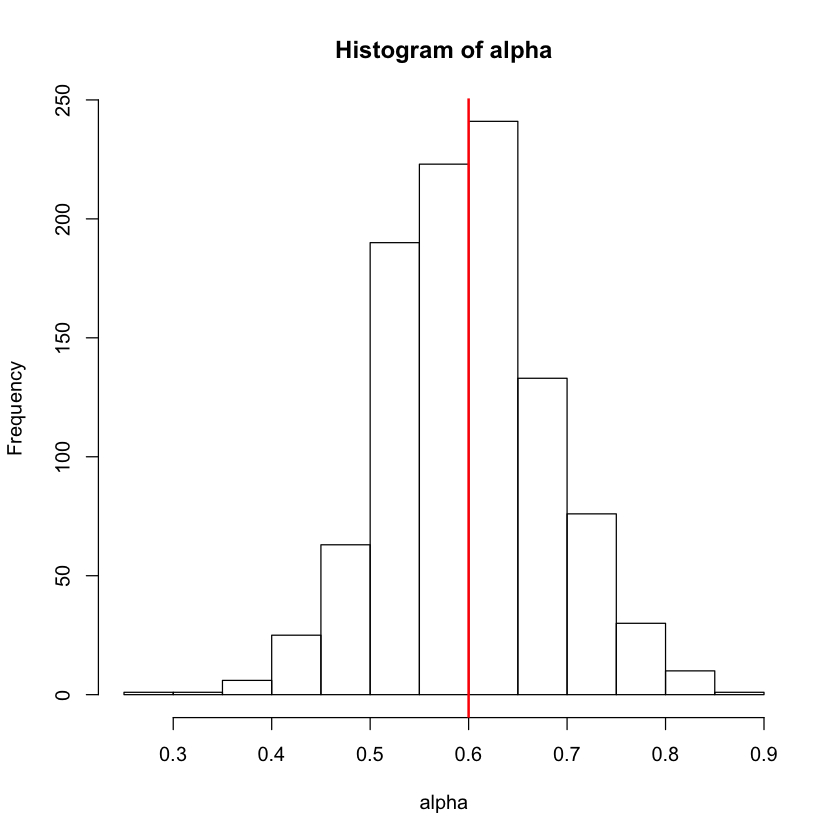

In [5]:
library(mvtnorm)
set.seed(1)
n <- 100
m <- 1000
sigmaX <- 1
sigmaY <- 1.25
sigmaXY <- 0.5
sigMat <- matrix(c(sigmaX,sigmaXY,sigmaXY,sigmaY),2,2)

alpha <- rep(0,m)
for(i in 1:m){
    returns <- rmvnorm(n,rep(0,2),sigMat)
    X <- returns[,1]
    Y <- returns[,2]
    alpha[i] <- (var(Y)-cov(X,Y))/(var(X)+var(Y)-2*cov(X,Y))
}
mean(alpha)
sd(alpha)
hist(alpha,10)
abline(v=0.6,col="red",lwd=2)

- The mean value of $m$ estimates of $\alpha$ is 0.6
- The standard error of $\hat{\alpha}$ is 0.082
- The practical issue is that __we cannot sample from the ground truth given a real dataset__.
- __Bootstrap__: we instead obtain distinct data sets by repeatedly sampling observations from the __original data set__. That syas the standard error of $\hat{\alpha}$ is estimated by
$$\sqrt{\frac{1}{B-1}\sum_{i=1}^B(\hat{\alpha}^*_i-\frac{1}{B}\sum_{i=1}^B\hat{\alpha}^*_i)}$$
where $\hat{\alpha}^*_i$ is the estimate of $\alpha$ using the $i$-th dataset sampled from the original dataset.

[1] 0.6266307

[1] 0.08073907

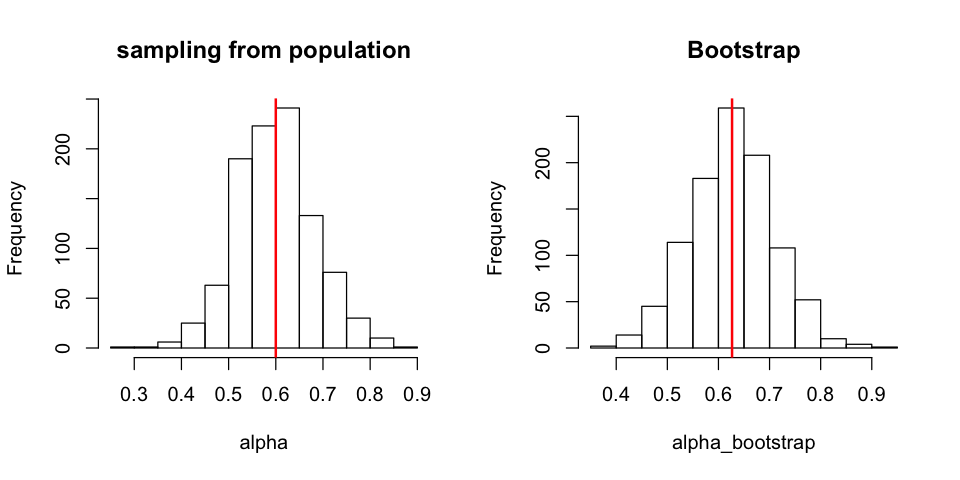

In [6]:
set.seed(1)
n <- 100
B <- 1000
returns <- rmvnorm(n,rep(0,2),sigMat) # the dataset is fixed once sampled

alpha_bootstrap <- rep(0,B)
for(i in 1:B){
    returns_i <- returns[sample(1:nrow(returns),n,replace = T),] # sample with replacement
    X <- returns_i[,1]
    Y <- returns_i[,2]
    alpha_bootstrap[i] <- (var(Y)-cov(X,Y))/(var(X)+var(Y)-2*cov(X,Y))
}

library(repr)
options(repr.plot.width=8, repr.plot.height=4)
par(mfrow=c(1,2))
hist(alpha,10,main = "sampling from population")
abline(v=0.6,col="red",lwd=2)
mean(alpha_bootstrap)
sd(alpha_bootstrap)
hist(alpha_bootstrap,10,main="Bootstrap")
abline(v=mean(alpha_bootstrap),col="red",lwd=2)

- The mean value of $B$ bootstrap estimates of $\alpha$ is 0.62
- The bootstrap standard error of $\hat{\alpha}$ is 0.08
- These quantities are very close to the ones obtained by sampling from the population.
- __Note: we only use bootstrap to estimate the standard error of $\hat{\alpha}$, the estimate of $\alpha$ should be be computed using the whole dastaset as what we did before.__